In [1]:
import pandas as pd
from sqlalchemy import create_engine
import geopandas as gpd

import os

# Database connection details from zshrc environment variables
db_name = 'colorado_spills'
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')


# Create an engine to connect to the PostgreSQL database
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{db_name}')

# Function to load data from a table
def load_table(table_name):
    query = f'SELECT * FROM {table_name}'
    df = pd.read_sql(query, engine)
    return df

# Load the spills and demographics data
spills_with_demographics = load_table('spills_with_demographics')

In [2]:
print(spills_with_demographics.columns.tolist())


['Document #', 'Report', 'Operator', 'Operator #', 'Tracking #', 'Initial Report Date', 'Date of Discovery', 'Spill Type', 'Qtr Qtr', 'Section', 'Township', 'range', 'meridian', 'Latitude', 'Longitude', 'Municipality', 'county', 'Facility Type', 'Facility ID', 'API County Code', 'API Sequence Number', 'Spilled outside of berms', 'More than five barrels spilled', 'Oil Spill Volume', 'Condensate Spill Volume', 'Flow Back Spill Volume', 'Produced Water Spill Volume', 'E&P Waste Spill Volume', 'Other Waste', 'Drilling Fluid Spill Volume', 'Current Land Use', 'Other Land Use', 'Weather Conditions', 'Surface Owner', 'Surface Owner Other', 'Waters of the State', 'Residence / Occupied Structure', 'livestock', 'Public Byway', 'Surface Water Supply Area', 'Spill Description', 'Supplemental Report Date', 'Oil BBLs Spilled', 'Oil BBLs Recovered', 'Oil Unknown', 'Condensate BBLs Spilled', 'Condensate BBLs Recovered', 'Condensate Unknown', 'Produced Water BBLs Spilled', 'Produced Water BBLs Recovere

In [3]:
import pandas as pd

date_columns = ['Initial Report Date', 'Date of Discovery', 'Supplemental Report Date', 'Supplemental Report Date CA']

for col in date_columns:
    spills_with_demographics[col] = pd.to_datetime(spills_with_demographics[col], errors='coerce')

# Check the result
print(spills_with_demographics[date_columns].dtypes)

Initial Report Date            datetime64[ns]
Date of Discovery              datetime64[ns]
Supplemental Report Date       datetime64[ns]
Supplemental Report Date CA    datetime64[ns]
dtype: object


In [8]:
import numpy as np

def clean_and_convert(x):
    if isinstance(x, str):
        # Remove any non-numeric characters except decimal point
        x = ''.join(c for c in x if c.isdigit() or c == '.')
        return float(x) if x else np.nan
    return x

spills_with_demographics['Oil Spill Volume'] = spills_with_demographics['Oil Spill Volume'].apply(clean_and_convert)
spills_with_demographics['Produced Water Spill Volume'] = spills_with_demographics['Produced Water Spill Volume'].apply(clean_and_convert)

# Convert to numeric type
spills_with_demographics['Oil Spill Volume'] = pd.to_numeric(spills_with_demographics['Oil Spill Volume'], errors='coerce')
spills_with_demographics['Produced Water Spill Volume'] = pd.to_numeric(spills_with_demographics['Produced Water Spill Volume'], errors='coerce')

# Check the result
print(spills_with_demographics[['Oil Spill Volume', 'Produced Water Spill Volume']].dtypes)

Oil Spill Volume               float64
Produced Water Spill Volume    float64
dtype: object


In [10]:
# Count of spills per year
spills_per_year = spills_with_demographics['Year'].value_counts().sort_index()
print("Spills per year:")
print(spills_per_year)

# Sum of spill volumes by year
yearly_total_volumes = spills_with_demographics.groupby('Year').agg({
    'Oil Spill Volume': lambda x: x.astype(float).sum(skipna=True),
    'Produced Water Spill Volume': lambda x: x.astype(float).sum(skipna=True)
})
print("\nTotal spill volumes by year:")
print(yearly_total_volumes)

# Average spill volumes by year
yearly_avg_volumes = yearly_total_volumes.div(spills_per_year, axis=0)
print("\nAverage spill volumes by year:")
print(yearly_avg_volumes)

# Correlation between time to report and spill volume
correlation = spills_with_demographics[['Days to Report', 'Oil Spill Volume', 'Produced Water Spill Volume']].corr(method='spearman')
print("\nSpearman Correlation between reporting delay and spill volumes:")
print(correlation)

Spills per year:
Year
1994       1
2004       1
2009       3
2010       8
2011       5
2012       7
2013      21
2014    1099
2015    1580
2016    1373
2017    1599
2018    1581
2019    1557
2020    1166
2021    1790
2022    2155
2023    2080
2024     864
Name: count, dtype: int64

Total spill volumes by year:
      Oil Spill Volume  Produced Water Spill Volume
Year                                               
1994               0.0                          0.0
2004               0.0                          1.0
2009               0.0                          0.0
2010               0.0                          0.0
2011               0.0                      10200.0
2012               3.0                      30700.0
2013               0.0                      46115.0
2014          404477.0                    1080000.0
2015          553498.0                    1977935.0
2016          590644.0                    1811414.0
2017          637575.0                    1514706.0
2018        

In [6]:
# Average demographic characteristics of spill locations by year
yearly_demographics = spills_with_demographics.groupby('Year')[['percent_white', 'percent_hispanic', 'median_household_income', 'percent_poverty']].mean()
print("\nAverage demographic characteristics of spill locations by year:")
print(yearly_demographics)

# Correlation between spill frequency and demographic characteristics
spills_per_tract = spills_with_demographics.groupby('GEOID').size().reset_index(name='spill_count')
tract_demographics = spills_with_demographics.groupby('GEOID')[['percent_white', 'percent_hispanic', 'median_household_income', 'percent_poverty']].first()
tract_analysis = pd.merge(spills_per_tract, tract_demographics, on='GEOID')
correlation = tract_analysis[['spill_count', 'percent_white', 'percent_hispanic', 'median_household_income', 'percent_poverty']].corr()
print("\nCorrelation between spill frequency and demographic characteristics:")
print(correlation['spill_count'])


Average demographic characteristics of spill locations by year:
      percent_white  percent_hispanic  median_household_income  \
Year                                                             
1994      28.591783         23.557350             1.012500e+05   
2004      79.166667         10.784314             1.436460e+05   
2009      81.660008         20.347086             7.067033e+04   
2010      77.983425         22.914365             6.457300e+04   
2011      83.450494         28.346579             8.144260e+04   
2012      84.676145         11.650869             5.971800e+04   
2013      80.786704         26.118158             6.534219e+04   
2014      82.974270         23.382431            -9.629444e+06   
2015      83.703315         22.309731            -4.142396e+06   
2016      83.478642         23.321560            -4.295124e+06   
2017      83.914508         21.828941            -7.426691e+06   
2018      84.082954         21.682858             7.731813e+04   
2019      8

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Ensure 'Days to Report' is calculated correctly
spills_with_demographics['Days to Report'] = (spills_with_demographics['Initial Report Date'] - spills_with_demographics['Date of Discovery']).dt.days

# List of EJ variables we'll examine
ej_variables = ['percent_white', 'percent_hispanic', 'median_household_income', 'percent_poverty', 'unemployment_rate']

# Remove any rows with missing values in these columns
analysis_df = spills_with_demographics.dropna(subset=['Days to Report'] + ej_variables)

print(f"Number of spills for analysis: {len(analysis_df)}")

Number of spills for analysis: 16886


Correlations with Days to Report:
percent_white             -0.033242
percent_poverty           -0.011415
unemployment_rate         -0.008741
percent_hispanic          -0.003342
median_household_income    0.005737
Days to Report             1.000000
Name: Days to Report, dtype: float64


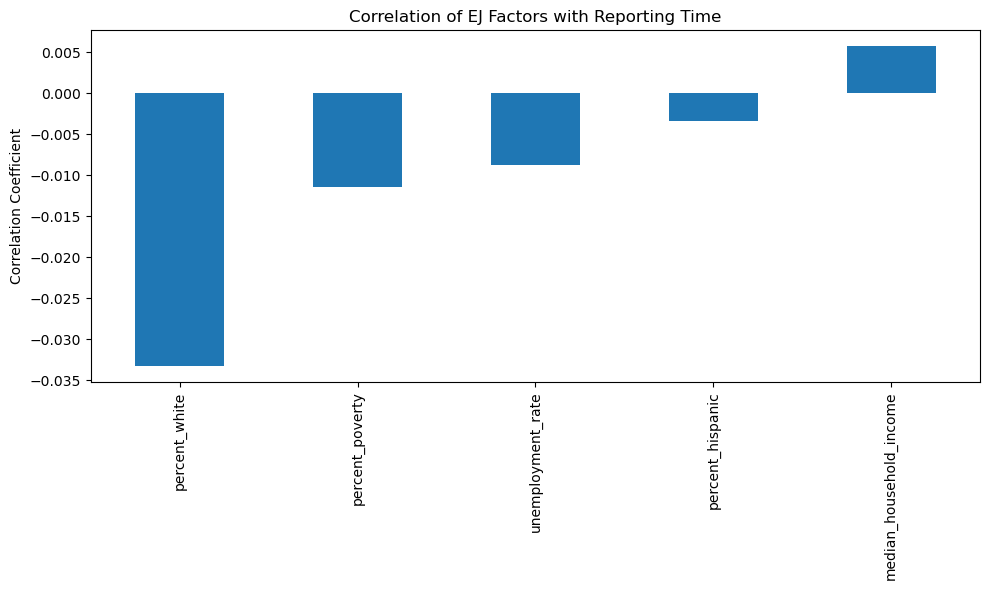

In [12]:
# Calculate correlations
correlations = analysis_df[['Days to Report'] + ej_variables].corr()['Days to Report'].sort_values()

print("Correlations with Days to Report:")
print(correlations)

# Visualize correlations
plt.figure(figsize=(10, 6))
correlations.drop('Days to Report').plot(kind='bar')
plt.title('Correlation of EJ Factors with Reporting Time')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

Number of spills for analysis: 16886


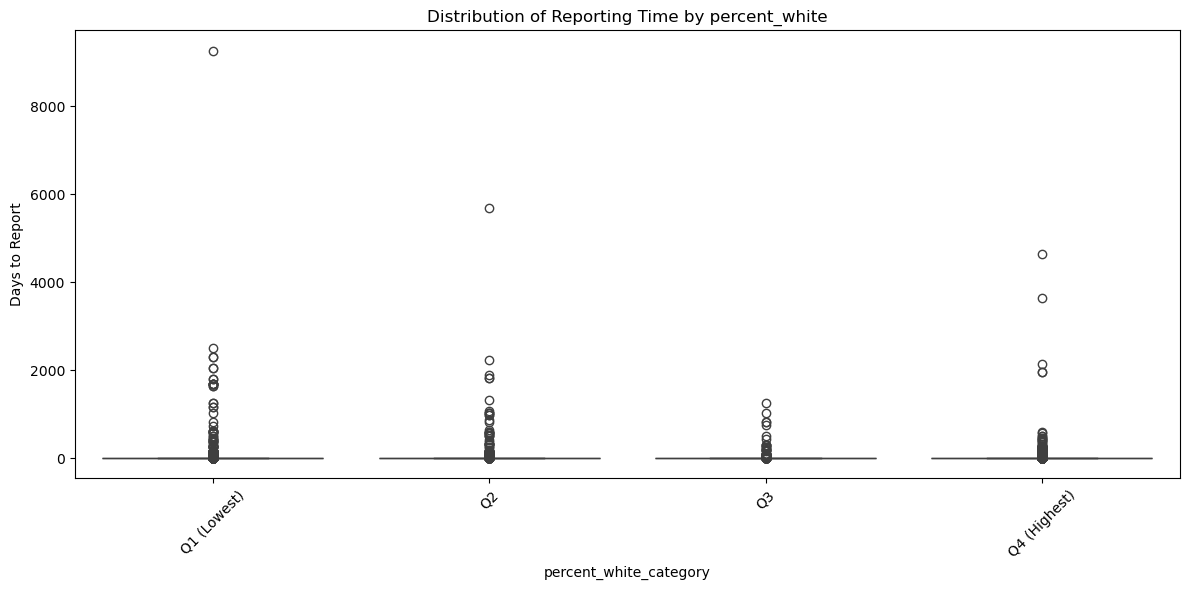

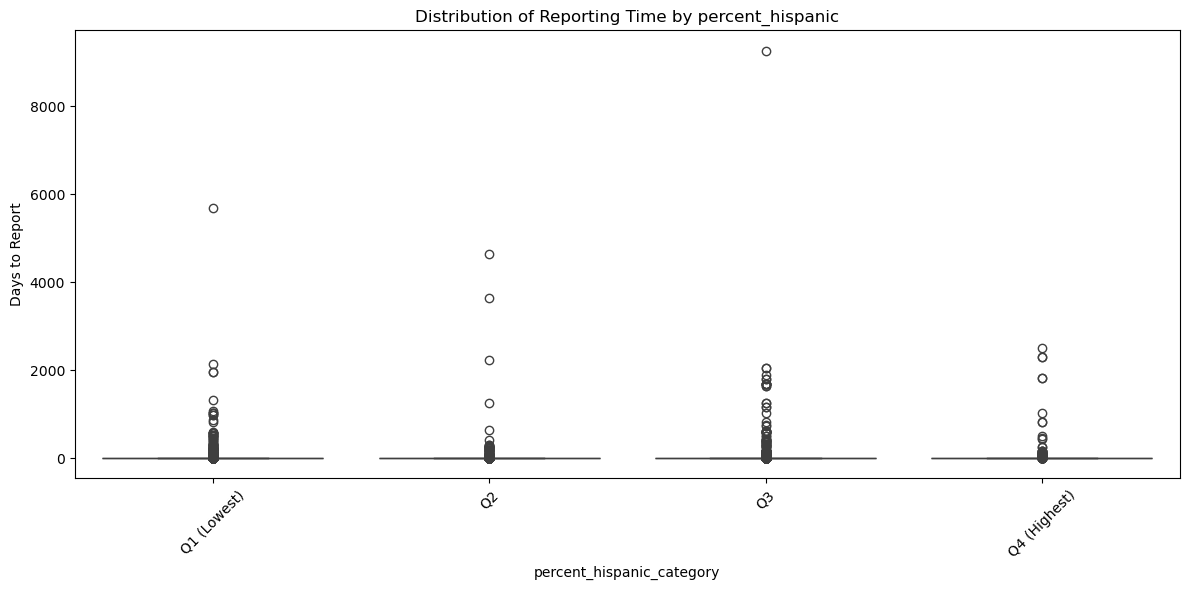

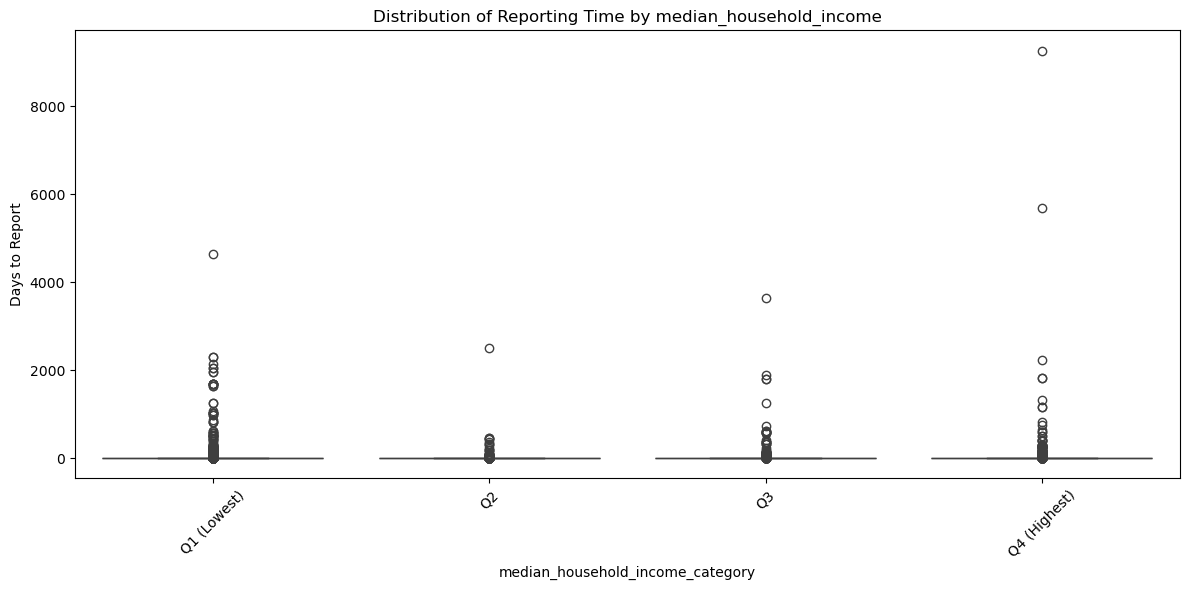

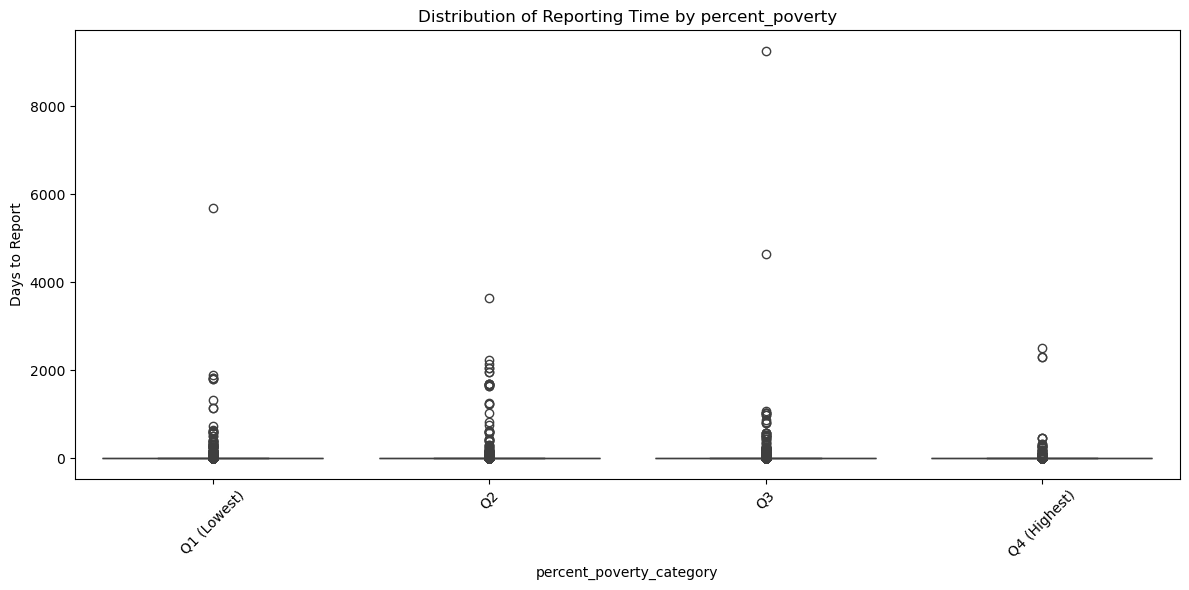

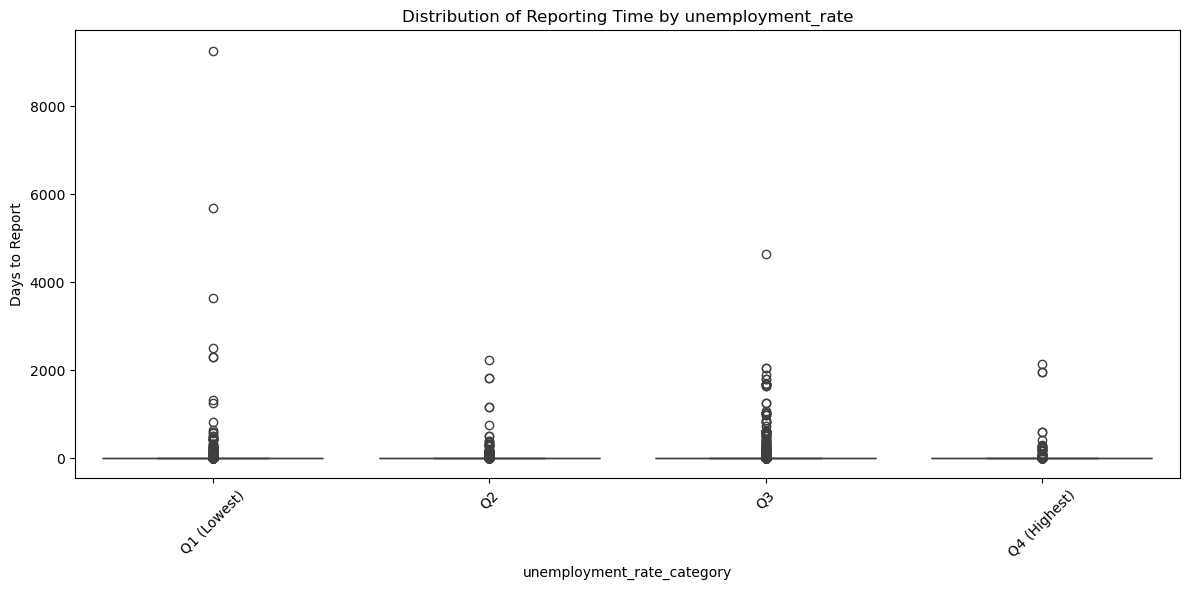

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Create a copy of the DataFrame to work with
analysis_df = spills_with_demographics.copy()

# Ensure 'Days to Report' is calculated correctly
analysis_df['Days to Report'] = (analysis_df['Initial Report Date'] - analysis_df['Date of Discovery']).dt.days

# List of EJ variables we'll examine
ej_variables = ['percent_white', 'percent_hispanic', 'median_household_income', 'percent_poverty', 'unemployment_rate']

# Remove any rows with missing values in these columns
analysis_df = analysis_df.dropna(subset=['Days to Report'] + ej_variables)

print(f"Number of spills for analysis: {len(analysis_df)}")

# Function to categorize tracts into quartiles
def categorize_quartiles(series):
    return pd.qcut(series, q=4, labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'])

# Create categorical variables for each EJ factor
for var in ej_variables:
    analysis_df[f'{var}_category'] = categorize_quartiles(analysis_df[var])

# Function to plot boxplots
def plot_boxplots(variable):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=f'{variable}_category', y='Days to Report', data=analysis_df)
    plt.title(f'Distribution of Reporting Time by {variable}')
    plt.ylabel('Days to Report')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot boxplots for each EJ variable
for var in ej_variables:
    plot_boxplots(var)

In [18]:
# Function to perform ANOVA
def perform_anova(variable):
    categories = analysis_df[f'{variable}_category'].unique()
    samples = [group['Days to Report'].values for name, group in analysis_df.groupby(f'{variable}_category', observed=True)]
    f_value, p_value = stats.f_oneway(*samples)
    return f_value, p_value

# Perform ANOVA for each EJ variable
for var in ej_variables:
    f_value, p_value = perform_anova(var)
    print(f"ANOVA results for {var}:")
    print(f"F-value: {f_value:.4f}")
    print(f"p-value: {p_value:.4f}")
    print()

ANOVA results for percent_white:
F-value: 3.4856
p-value: 0.0151

ANOVA results for percent_hispanic:
F-value: 2.8655
p-value: 0.0352

ANOVA results for median_household_income:
F-value: 7.6346
p-value: 0.0000

ANOVA results for percent_poverty:
F-value: 3.3987
p-value: 0.0170

ANOVA results for unemployment_rate:
F-value: 5.1023
p-value: 0.0016



Original dataset size: 16886
Dataset size after cleaning: 10916
Number of records removed: 5970

Correlation Matrix:
                         Days to Report  percent_white  percent_hispanic  \
Days to Report                 1.000000      -0.012665          0.001356   
percent_white                 -0.012665       1.000000         -0.641930   
percent_hispanic               0.001356      -0.641930          1.000000   
median_household_income        0.007872       0.113642         -0.259411   
percent_poverty               -0.027037      -0.204533          0.049957   
unemployment_rate             -0.002549       0.074651         -0.120400   

                         median_household_income  percent_poverty  \
Days to Report                          0.007872        -0.027037   
percent_white                           0.113642        -0.204533   
percent_hispanic                       -0.259411         0.049957   
median_household_income                 1.000000        -0.585739   
perce

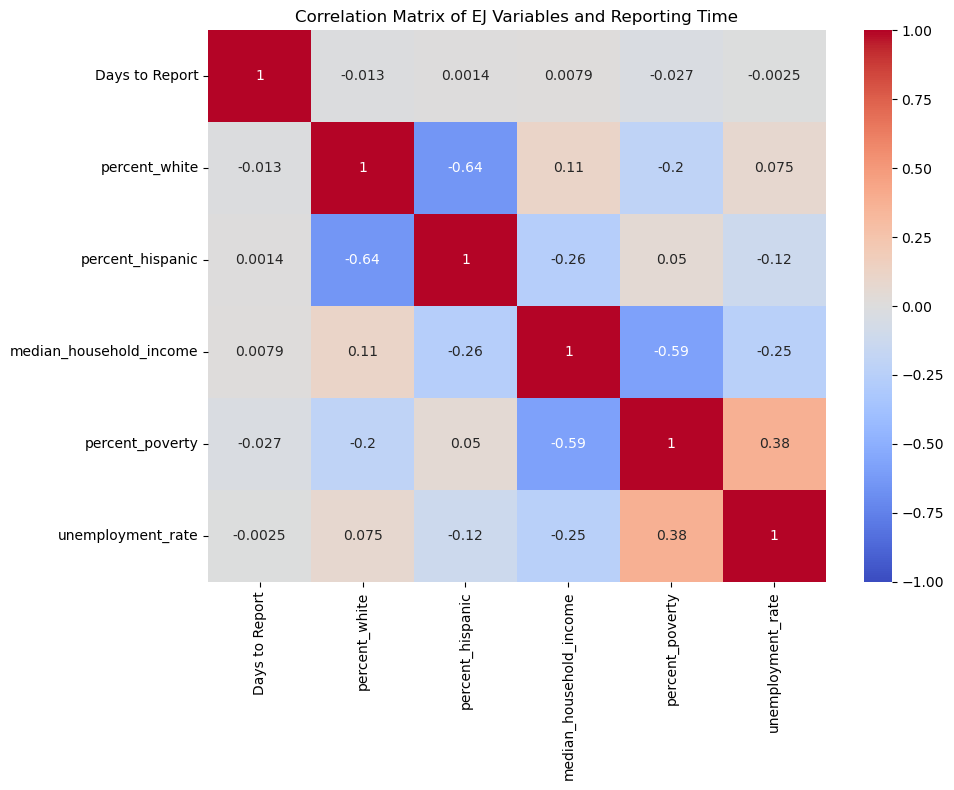

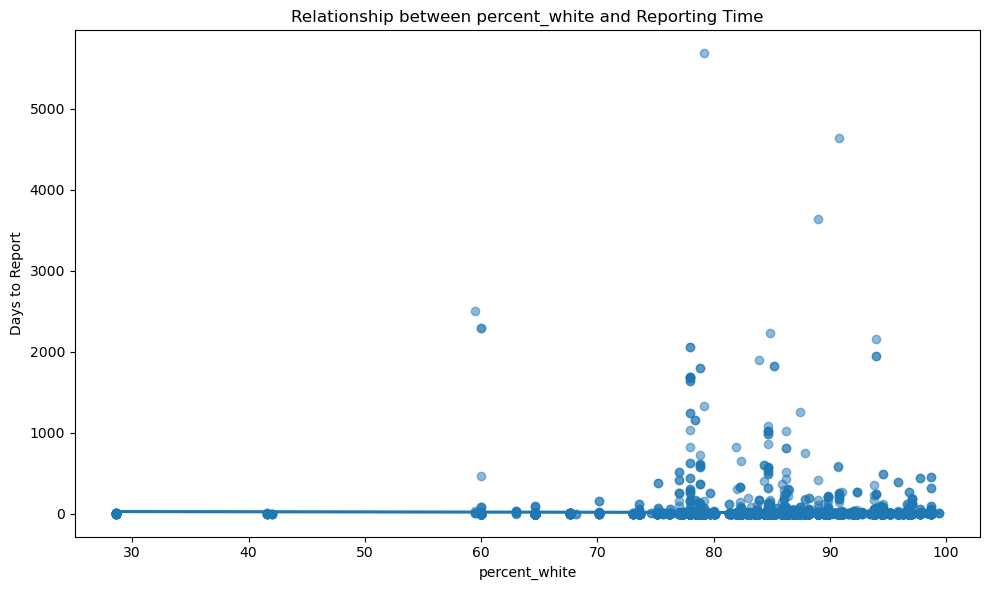

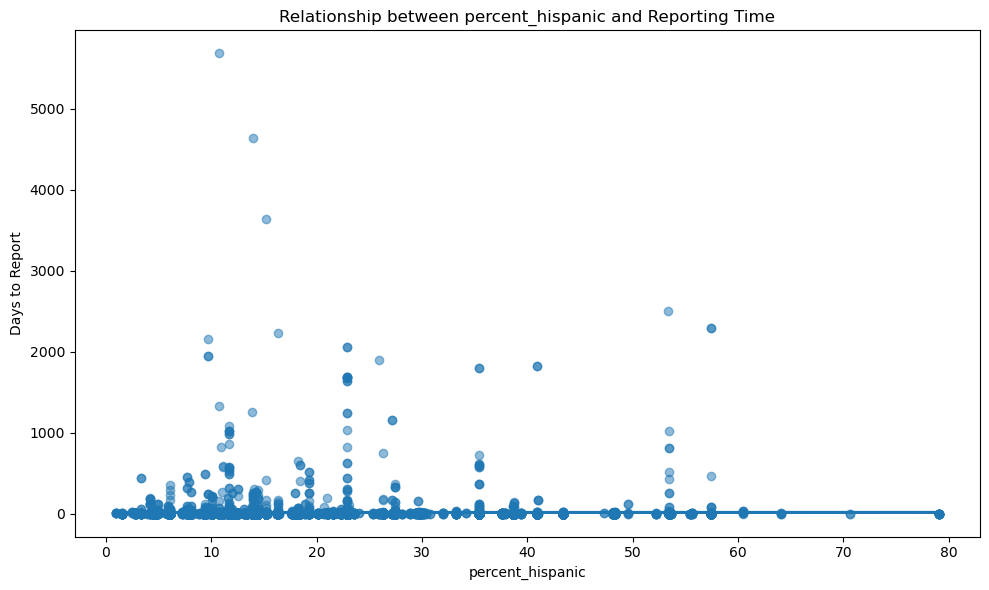

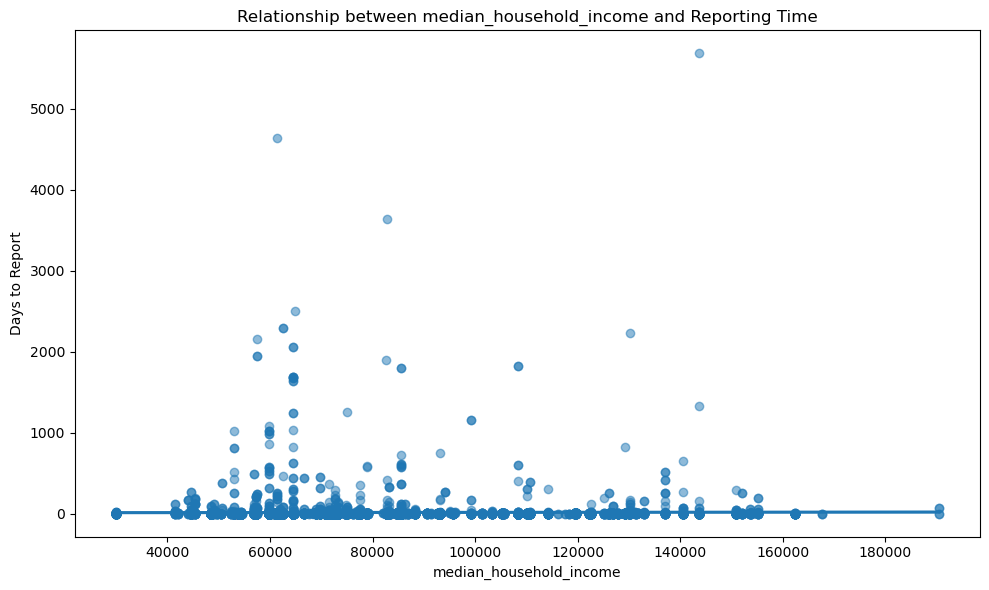

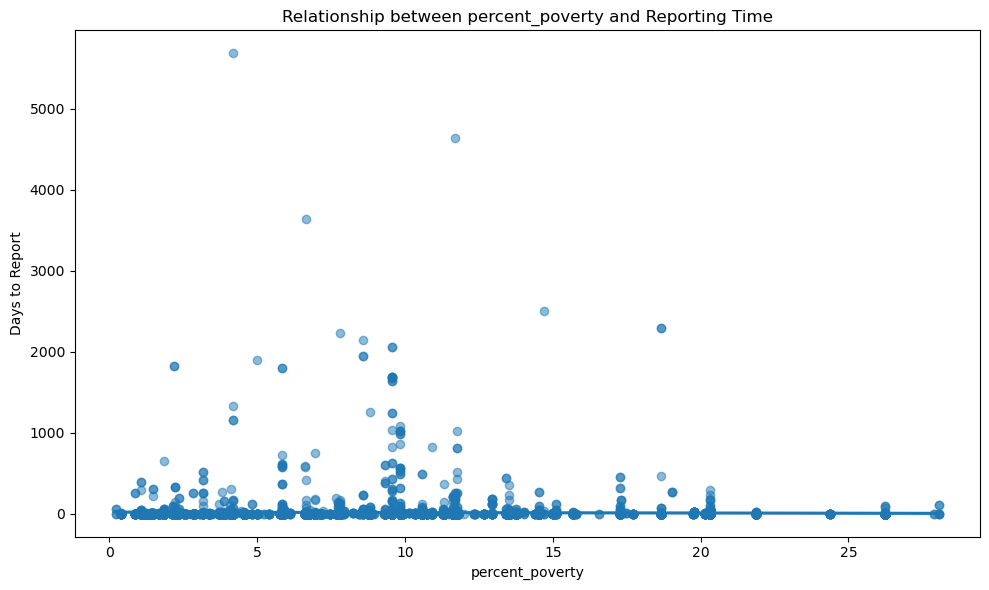

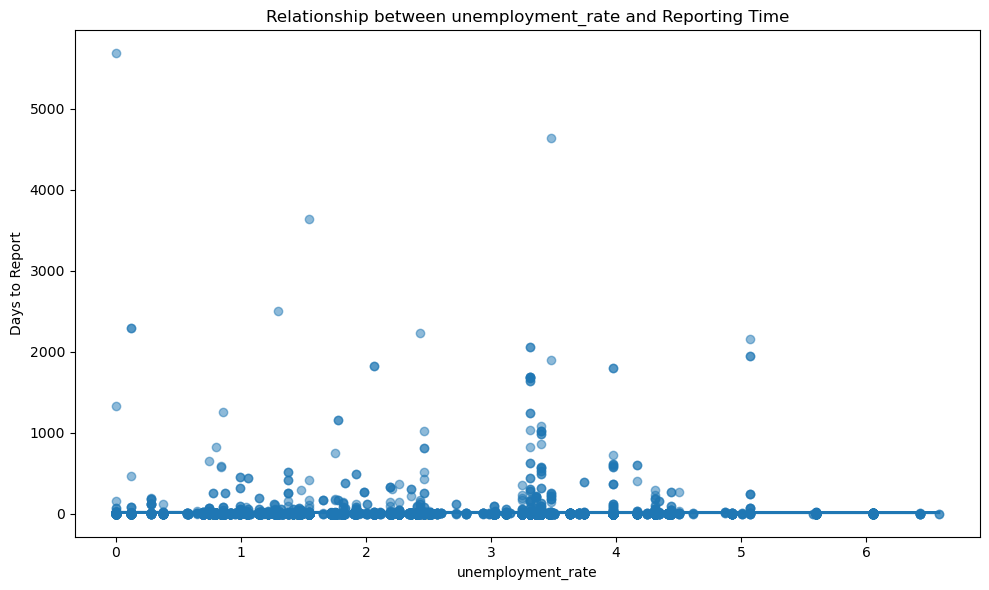

                            OLS Regression Results                            
Dep. Variable:         Days to Report   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.450
Date:                Fri, 09 Aug 2024   Prob (F-statistic):            0.00407
Time:                        14:17:50   Log-Likelihood:                -68649.
No. Observations:               10916   AIC:                         1.373e+05
Df Residuals:                   10910   BIC:                         1.374e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

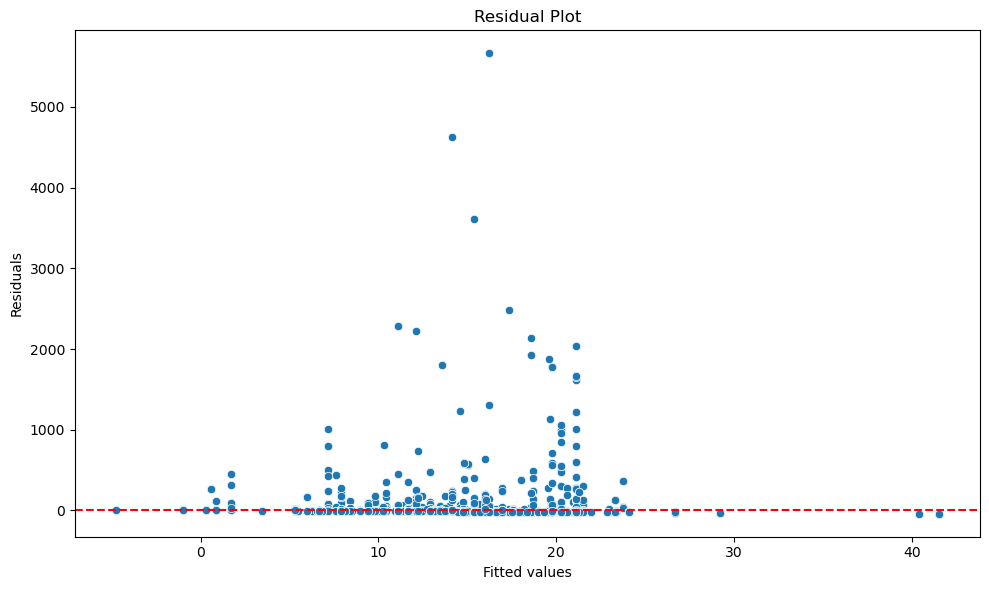

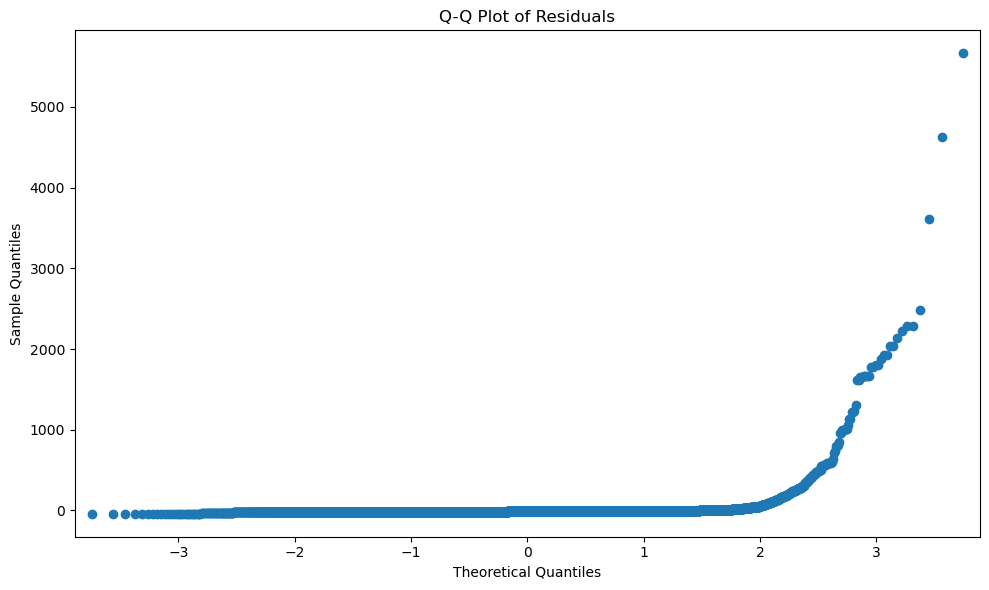


Variance Inflation Factors:
                  Variable         VIF
0                    const  365.555860
1            percent_white    1.935037
2         percent_hispanic    2.020569
3  median_household_income    1.783219
4          percent_poverty    1.906722
5        unemployment_rate    1.212996


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Remove extreme outliers (above 8000 days), ensure positive days, and remove negative incomes
analysis_df_cleaned = analysis_df[
    (analysis_df['Days to Report'] <= 8000) & 
    (analysis_df['Days to Report'] > 0) &
    (analysis_df['median_household_income'] > 0)
]

print(f"Original dataset size: {len(analysis_df)}")
print(f"Dataset size after cleaning: {len(analysis_df_cleaned)}")
print(f"Number of records removed: {len(analysis_df) - len(analysis_df_cleaned)}")

# List of EJ variables
ej_variables = ['percent_white', 'percent_hispanic', 'median_household_income', 'percent_poverty', 'unemployment_rate']

# Correlation matrix
correlation_matrix = analysis_df_cleaned[['Days to Report'] + ej_variables].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of EJ Variables and Reporting Time')
plt.tight_layout()
plt.show()

# Scatter plots with regression lines
for var in ej_variables:
    plt.figure(figsize=(10, 6))
    sns.regplot(x=var, y='Days to Report', data=analysis_df_cleaned, scatter_kws={'alpha':0.5})
    plt.title(f'Relationship between {var} and Reporting Time')
    plt.xlabel(var)
    plt.ylabel('Days to Report')
    plt.tight_layout()
    plt.show()

# Multiple Linear Regression
X = sm.add_constant(analysis_df_cleaned[ej_variables])
y = analysis_df_cleaned['Days to Report']
model = sm.OLS(y, X).fit()
print(model.summary())

# Residual Analysis
residuals = model.resid
fitted_values = model.fittedvalues

plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

# Q-Q plot for normality check
fig, ax = plt.subplots(figsize=(10, 6))
sm.qqplot(residuals, ax=ax)
ax.set_title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

# Variance Inflation Factor for multicollinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factors:")
print(vif_data)

Total rows in original dataset: 16886
Rows kept: 10916
Rows removed: 5970


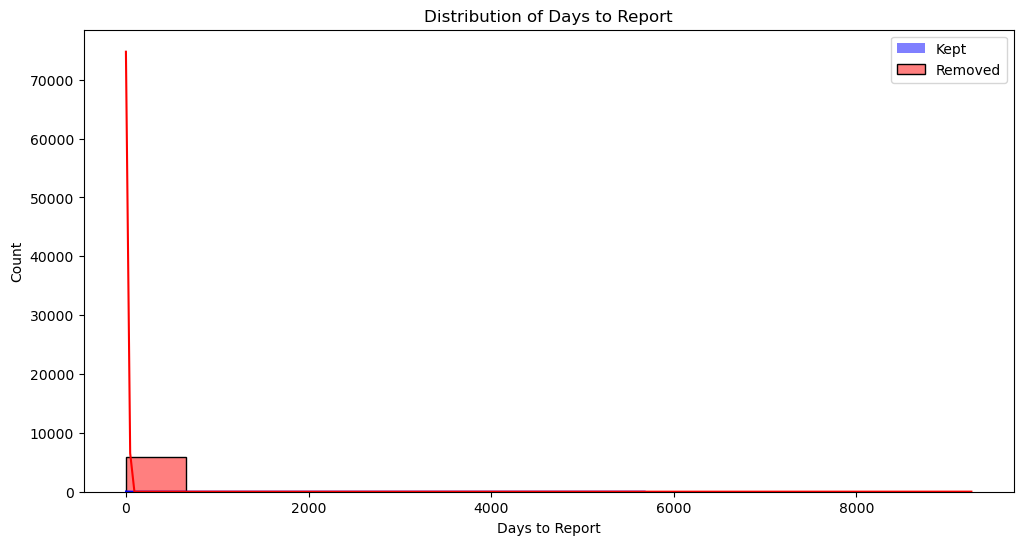

KeyboardInterrupt: 

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame of removed rows
removed_df = analysis_df[
    (analysis_df['Days to Report'] > 8000) | 
    (analysis_df['Days to Report'] <= 0) |
    (analysis_df['median_household_income'] <= 0)
]

# Create a DataFrame of kept rows
kept_df = analysis_df_cleaned

print(f"Total rows in original dataset: {len(analysis_df)}")
print(f"Rows kept: {len(kept_df)}")
print(f"Rows removed: {len(removed_df)}")

# Function to compare distributions
def compare_distributions(variable):
    plt.figure(figsize=(12, 6))
    sns.histplot(kept_df[variable], kde=True, color='blue', alpha=0.5, label='Kept')
    sns.histplot(removed_df[variable], kde=True, color='red', alpha=0.5, label='Removed')
    plt.title(f'Distribution of {variable}')
    plt.legend()
    plt.show()

# Compare distributions for key variables
for var in ['Days to Report', 'median_household_income'] + ej_variables:
    compare_distributions(var)

# Summary statistics for removed rows
print("\nSummary statistics for removed rows:")
print(removed_df.describe())

# Count of rows removed for each reason
reason_counts = {
    'Days > 8000': sum(removed_df['Days to Report'] > 8000),
    'Days <= 0': sum(removed_df['Days to Report'] <= 0),
    'Income <= 0': sum(removed_df['median_household_income'] <= 0)
}
print("\nReason for removal:")
for reason, count in reason_counts.items():
    print(f"{reason}: {count}")

# Check for any patterns in categorical variables
categorical_vars = ['Spill Type', 'county', 'Facility Type']  # Add any other relevant categorical variables
for var in categorical_vars:
    if var in removed_df.columns:
        print(f"\nTop 10 {var} in removed data:")
        print(removed_df[var].value_counts().head(10))